<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/mr0_diffusion_prep_STEAM_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq  &> /dev/null
!pip install MRzeroCore &> /dev/null

import numpy as np
import torch
import matplotlib.pyplot as plt
import pypulseq as pp
import MRzeroCore as mr0

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

Syntaxfehler.
Syntaxfehler.


# Diffusion prepared STEAM
We use a $T_2$ preparation module consisting of $90°$, $180°$, $-90°$ pulses and diffusion gradients.
To spoil away the FID, which might have a different random phase than the stored diffusion-prepped magnetization, we add extra spoilers after the $180°$ pulse and during the prewinder phase.

## Diffusion b-value calculation
Diffusion reduces the magnetization by a factor of $e^{-bD}$, where $b$ is the sequence-specific b-value and $D$ the tissue-specific apperent diffusion coefficient.
For a diffusion gradient - refocusing RF pulse - diffusion gradient preparation like used here, the b-value can be calculated like follows:

$ b = (\gamma G)^2 \delta^2 \cdot (\Delta − \delta/3) $

where
- $\gamma$ is the Larmor frequency of water: $42.58 \, MHz / T$ or $267.5 \times 10^6 \, rad / T$
- $G$ is the gradient amplitude in $T / m$
- $\delta$ is the duration of the diffusion gradients
- $\Delta$ is the time from the start of the first gradient to the start of the second

Typical values for the apparent diffusion coefficient are:
| tissue       | ADC $[10^{-3} \, mm^2 / s]$ |
| ------------ | ---------------------- |
|  gray matter |                   0.83 |
| white matter |                   0.65 |
|          CSF |                   3.19 |

In [107]:
experiment_id = 'mr0_diffusion_prepped_STEAM_2D'

# Still plays out the preparation block but without diffusion gradients
disable_diff_prep = False  # @param {type: "boolean"}
# How far to spoil FID and magnetization after readout (in multiples of k-space)
spoil_factor = 1.5  # @param {type: "slider", min:0, max:3, step:0.1}
# Centric (True) or linear (False) reordering
reorder_centric = True  # @param {type: "boolean"}
# Duration (in ms) of the diffusion preparation gradient at maximum amplitude
diff_grad_dur = 30e-3  # @param {type: "slider", min:1e-3, max:100e-3, step:0.1e-3}

fov = 200e-3
slice_thickness = 8e-3
Nread = 64
Nphase = 64
adc_dwell = 30e-6
rf_phase_cycling = 84 * np.pi / 180

# Scanner limits
system = pp.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
                 rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6,
                 grad_raster_time=50*10e-6)

In [108]:
#@title b-value calculation

# b = (γG)² δ² (Δ−δ/3) = ω² δ² (Δ−δ/3)
# [s/m^2] = [2π/s]^2 * [s]^2 * [s]
# Pulseq stores gradient amplitudes as frequencies (ω not G), so there is no γ in b-value calculation

delta = diff_grad_dur
Delta = delta + 1e-3 + system.rf_dead_time + system.rf_ringdown_time
b_value = (2 * np.pi * system.max_grad)**2 * delta**2 * (Delta - delta / 3)

print("gamma")
print(f"> {system.gamma * 1e-6:8.2f} MHz/m")
print("gradient amplitude")
print(f"> {system.max_grad * 1e-3:8.2f} kHz/m")
print(f"> {system.max_grad / system.gamma * 1e3:8.2f} mT/m")
print("b-value")
print(f"> {b_value*1e-6:8.2f} s/mm^2")

gamma
>    42.58 MHz/m
gradient amplitude
>  1192.13 kHz/m
>    28.00 mT/m
b-value
>  1066.45 s/mm^2


In [109]:
#@title Build the sequence

# preparation pulses, 1st excitation is slice selective
rf90, rf90_gz, rf90_gzr = pp.make_sinc_pulse(
    flip_angle= 90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf180 = pp.make_block_pulse(flip_angle=180 * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3, system=system)
rf90_store = pp.make_block_pulse(flip_angle=90 * np.pi / 180, phase_offset=180 * np.pi / 180,duration=1e-3, system=system)
# readout pulse
rf = pp.make_block_pulse(flip_angle=5 * np.pi / 180, duration=1e-3, system=system)

# preparation gradient for diffusion weighting
diff_grad = pp.make_trapezoid(channel='y', amplitude=system.max_grad, duration=diff_grad_dur, system=system)
# readout gradient
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nread * adc_dwell, system=system)
# move prepared mag away from k-space center for separation from FID
gx_store = pp.make_trapezoid(channel='x', area=-(gx.area / 2 + gx.area * spoil_factor), system=system)
# move STE (prepared mag) to start of k-space readout
gx_pre = pp.make_trapezoid(channel='x', area=gx.area * spoil_factor, duration=1.5e-3, system=system)
# spoil after each k-space line
gx_spoil = pp.make_trapezoid(channel='x', area=spoil_factor * gx.area, duration=1.5e-3, system=system)
# spoil transversal magnetization after preparation
gz_spoil = pp.make_trapezoid(channel='z', area=spoil_factor * gx.area, duration=1.5e-3, system=system)

adc = pp.make_adc(num_samples=Nread, dwell=adc_dwell, delay=gx.rise_time, system=system)


if disable_diff_prep:
    diff_grad = pp.make_delay(pp.calc_duration(diff_grad))

if reorder_centric:
    phenc = [i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]
else:
    phenc = [i - Nphase // 2 for i in range(Nphase)]


seq = pp.Sequence()
# STE preparation
seq.add_block(rf90, rf90_gz)
seq.add_block(diff_grad, rf90_gzr)
seq.add_block(rf180)
seq.add_block(diff_grad, gx_store)
seq.add_block(rf90_store)
seq.add_block(gz_spoil)

# FLASH readout
for jj in range(0, Nphase):
    rf.phase_offset = rf_phase_cycling * 0.5 * (jj**2 + jj + 2)
    adc.phase_offset = rf.phase_offset

    seq.add_block(rf)
    gp = pp.make_trapezoid(channel='y', area=phenc[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)

# write .seq file
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')

ok, errors = seq.check_timing()
if not ok:
    for error in errors:
        print(error, end="")

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


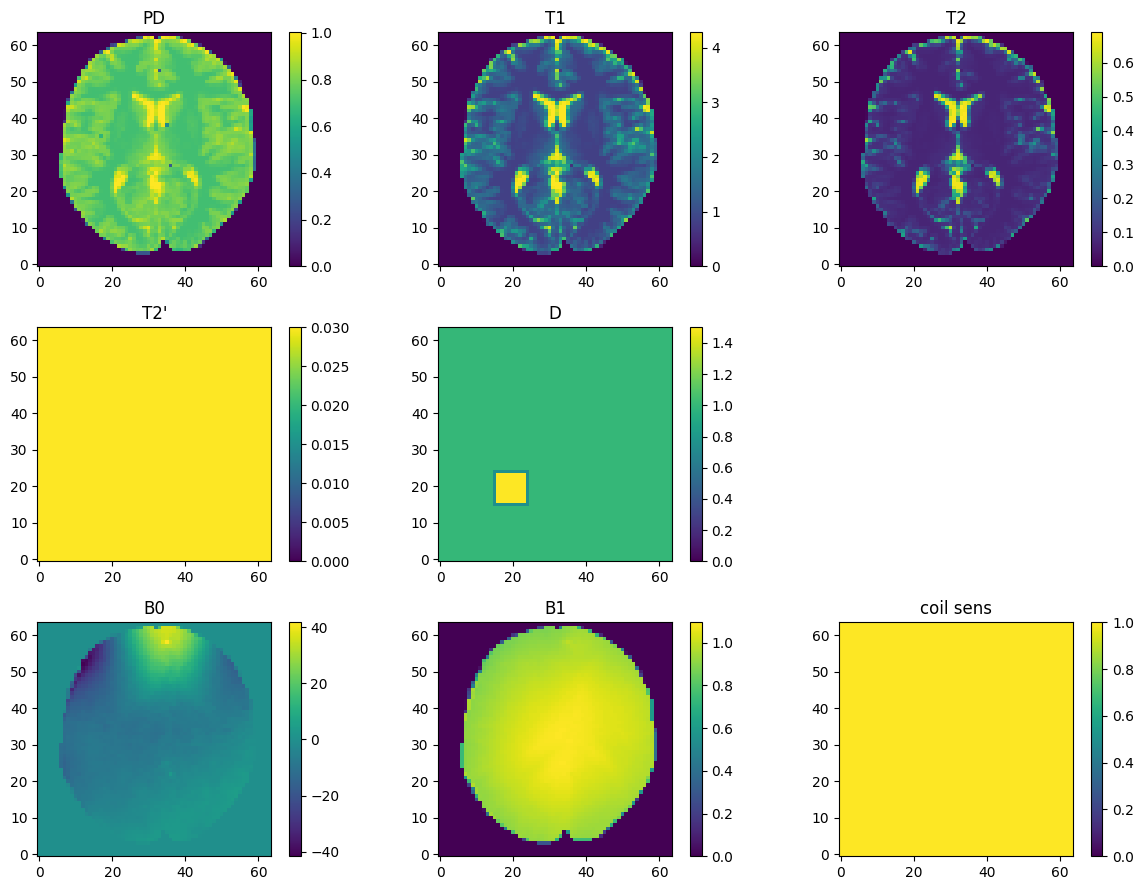

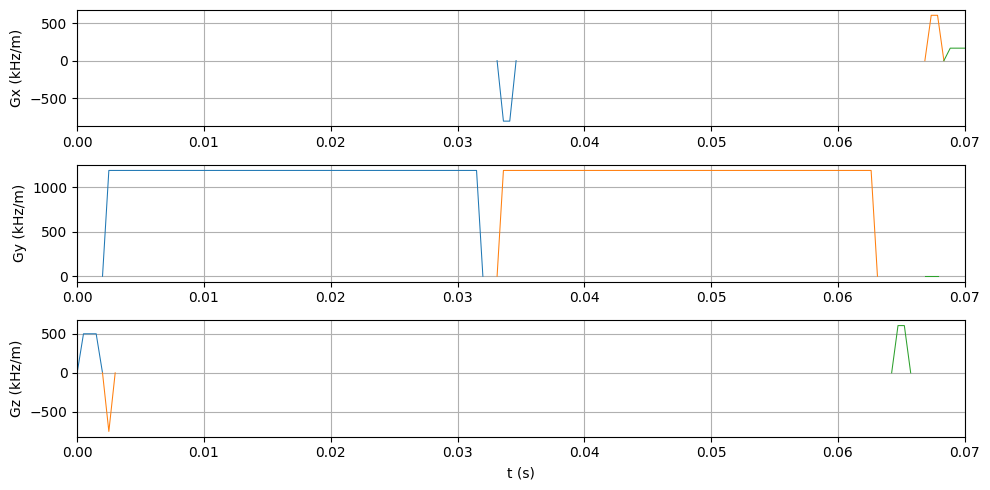

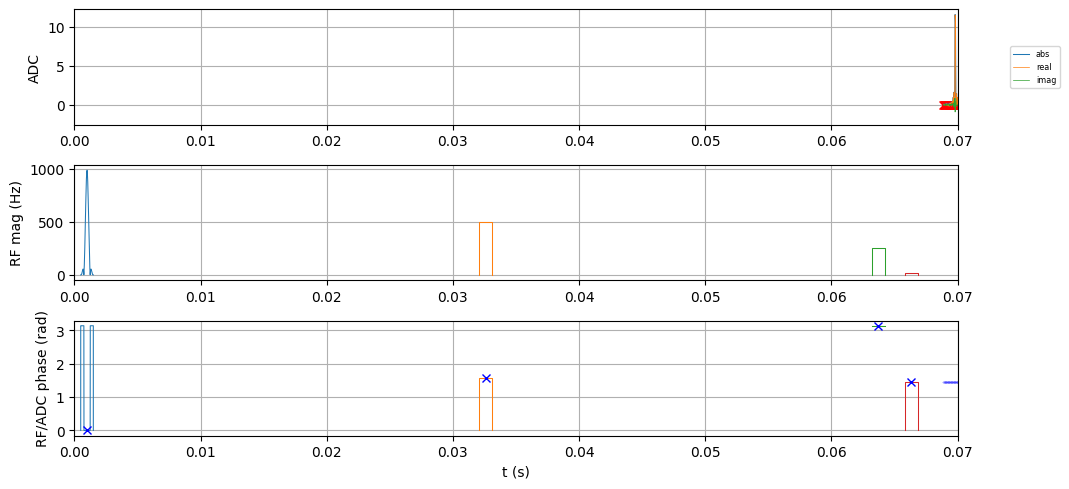

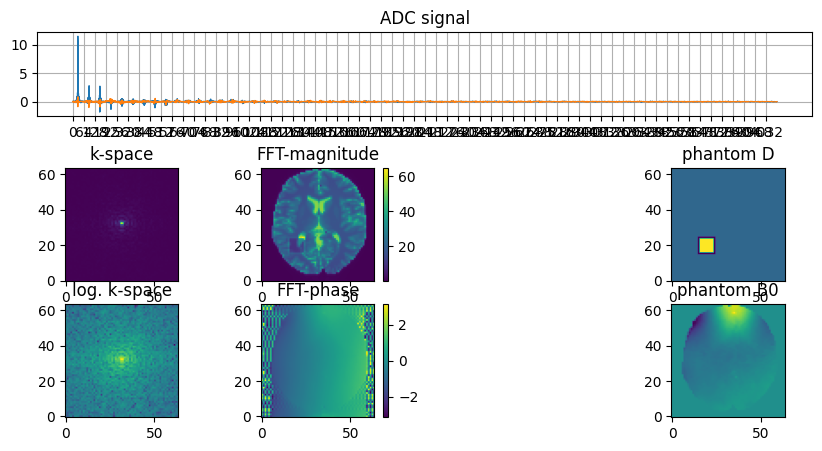

In [110]:
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
obj_p = mr0.util.load_default_phantom(sz[0], sz[1])
# (ii) insert rectangular "Tumor"
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
# mr0 uses D in units of 10^-3 * mm ^2/s  this is the same as µm^2/ms

obj_p.D*=1
if 1:
    # construct tumor border region
    for ii in range(15, 25):
        for jj in range(15, 25):
            obj_p.D[ii, jj] = torch.tensor(0.75)

    # construct tumor filling
    for ii in range(16, 24):
        for jj in range(16, 24):
            obj_p.D[ii, jj] = torch.tensor(1.5)

# Store PD and B0 for comparison
D = obj_p.D
B0 = obj_p.B0
D=obj_p.D
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
#seq0.plot_kspace_trajectory()

# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 2000, 1e-4)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False,time_range=(0,0.07))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

ipermvec = np.argsort(phenc)

kspace=kspace[:,ipermvec]
# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fft
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(345)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom D')
mr0.util.imshow(D)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
mr0.util.imshow(B0)

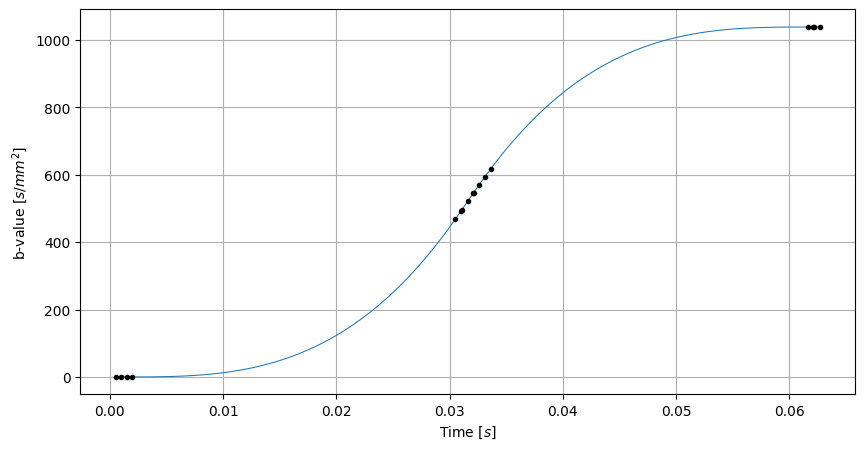

MR0 b-value: 1039.136512 s / mm^2


In [111]:
# Calculate the b-value from the MR0 sequence, identical to the main_pass.
# There is a refocussing pulse in the middle so we just flip the second grad
gradm = np.concatenate([seq0[0].gradm[:, 1], -seq0[1].gradm[:, 1]])
dt = np.concatenate([seq0[0].event_time, seq0[1].event_time])

k2 = np.cumsum(gradm)
# k2 is end of event, for integration we also need start of event (k1):
k1 = np.zeros_like(k2)
k1[1:] = k2[:-1]

# Integration over linear interpolation of k-space trajectory
b = 1/3 * (2 * np.pi)**2 * dt * (k1**2 + k1*k2 + k2**2)  # s/m^2

# Interpolate the trajectory for a finer plot
dt_i = np.full((100, ), dt.sum() / 100)
k2_i = np.interp(np.cumsum(dt_i), np.cumsum(dt), k2)
k1_i = np.zeros_like(k2_i)
k1_i[1:] = k2_i[:-1]
b_i = 1/3 * (2 * np.pi)**2 * dt_i * (k1_i**2 + k1_i*k2_i + k2_i**2)

plt.figure()
plt.plot(np.cumsum(dt_i), np.cumsum(b_i) * 1e-6)
plt.plot(np.cumsum(dt), np.cumsum(b) * 1e-6, "k.")
plt.xlabel("Time $[s]$")
plt.ylabel("b-value $[s / mm^2]$")
plt.grid()
plt.show()
print(f"MR0 b-value: {np.sum(b) * 1e-6} s / mm^2")

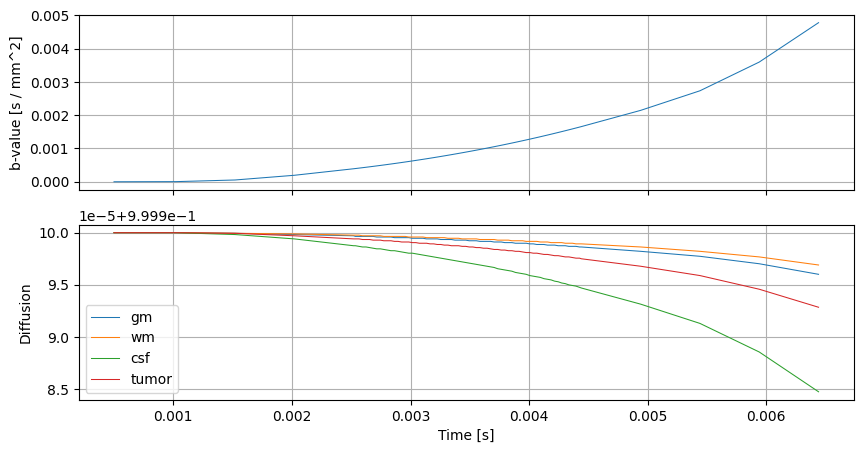

In [112]:
# Exemplary calculation of b-values and diffusion of simulated tissues for a single repetition

traj = seq0[10].gradm.cumsum(0)[:-2]
dt = seq0[10].event_time[:-2]
time = dt.cumsum(0)

k2 = traj[:, :3]
k1 = torch.zeros_like(k2)
k1[1:, :] = k2[:-1, :]
# Integrate over each event to get b factor (lin. interp. grad)
b = 1/3 * dt * (k1**2 + k1*k2 + k2**2).sum(1)  # s / m^2

# typical ADC values: 10^-3 mm^2/s = 10^-9 m^2 / s
# typical DWI b-values: up to 4000 s / mm^2

diffusion_gm = torch.exp(-1e-9 * 0.83 * torch.cumsum(b, 0)[:, None])
diffusion_wm = torch.exp(-1e-9 * 0.65 * torch.cumsum(b, 0)[:, None])
diffusion_csf = torch.exp(-1e-9 * 3.19 * torch.cumsum(b, 0)[:, None])
diffusion_tumor = torch.exp(-1e-9 * 1.5 * torch.cumsum(b, 0)[:, None])


plt.figure()
ax1 = plt.subplot(211)
plt.plot(time, b.cumsum(0) * 1e-6)
plt.ylabel("b-value [s / mm^2]")
plt.grid()
plt.tick_params("x", labelbottom=False)
plt.subplot(212, sharex=ax1)
plt.plot(time, diffusion_gm, label="gm")
plt.plot(time, diffusion_wm, label="wm")
plt.plot(time, diffusion_csf, label="csf")
plt.plot(time, diffusion_tumor, label="tumor")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Diffusion")
plt.show()